This notebook is for the Figure 7 analysis related to the imbalanced/rebalanced clustering metrics (ARI, AMI, Homogeneity, Completeness, and V-measure) and their use cases with toy simulated data and real single-cell RNA sequencing datasets.

In [5]:
import os 
import sys
sys.path.append("../../src/python/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from plotnine import *
import scanpy as sc
import anndata as ann
import scvi 
import bbknn 
from sklearn import metrics

from imbalanced_clustering import * 

In [4]:
# Change to top level dir
os.chdir("../../..")

### Case demonstration #1 - 3 classes 2 clusters imbalanced 

This first use-case utilizes simulated data to show the differences between the baseline and balanced clustering metrics in a scenario with 3 classes of differing size, and an inaccurate clustering result that utilizes k = 2 in kmeans. 

The results will be saved to tsv files to be plotted in R. 

In [28]:
# Define a function that returns values for imbalanced and balanced ARI, AMI, Homogeneity, 
# Completeness, and V-measure - for comparison downstream
def return_metrics(class_arr, cluster_arr):
    # Determine the imbalanced (base) metric scores 
    ari_imbalanced = adjusted_rand_score(class_arr, cluster_arr)
    ami_imbalanced = adjusted_mutual_info_score(class_arr, cluster_arr)
    homog_imbalanced = homogeneity_score(class_arr, cluster_arr)
    complete_imbalanced = completeness_score(class_arr, cluster_arr)
    v_measure_imbalanced = v_measure_score(class_arr, cluster_arr)

    # Determine the balanced metrics from `imbalanced-clustering`
    ari_balanced = balanced_adjusted_rand_index(class_arr, cluster_arr)
    ami_balanced = balanced_adjusted_mutual_info(class_arr, cluster_arr)
    homog_balanced = balanced_homogeneity(class_arr, cluster_arr)
    complete_balanced = balanced_completeness(class_arr, cluster_arr)
    v_measure_balanced = balanced_v_measure(class_arr, cluster_arr)
    
    # Return paired balanced imbalance scores
    return (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced)

# Define a function that takes the return of 'return_metrics' and collapses the result
# into a dataframe for saving
def return_metrics_to_df(output, trial_name):
    # Unpack the output into the appropriate values 
    (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced) = output 
    
    # Create a dataframe of the results 
    metrics = [
        "ARI imbalanced",
        "AMI imbalanced",
        "Homogeneity imbalanced",
        "Completeness imbalanced",
        "V-measure imbalanced",
        "ARI balanced",
        "AMI balanced",
        "Homogeneity balanced",
        "Completeness balanced",
        "V-measure balanced"
    ]
    metrics_results = [
        ari_imbalanced,
        ami_imbalanced,
        homog_imbalanced,
        complete_imbalanced,
        v_measure_imbalanced,
        ari_balanced,
        ami_balanced,
        homog_balanced,
        complete_balanced,
        v_measure_balanced
    ]
    metrics_type = [
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "balanced",
        "balanced",
        "balanced",
        "balanced",
        "balanced"
    ]
    metrics_df = pd.DataFrame({
        "Metric": metrics,
        "Value": metrics_results,
        "Type": metrics_type
    })
    metrics_df["Trial"] = trial_name
    
    # Return dataframe of results
    return metrics_df


Class scatterplot:


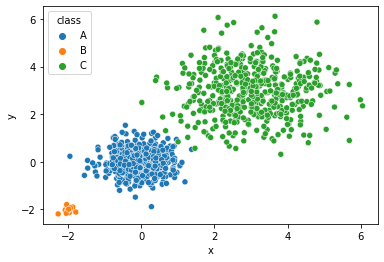

K-means classification scatterplot:


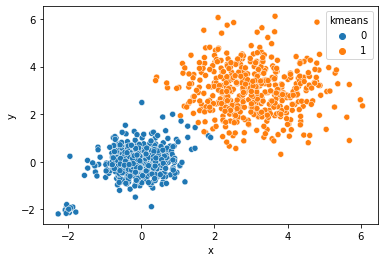

ARI imbalanced: 0.915 ARI balanced: 0.5434
AMI imbalanced: 0.8671 AMI balanced: 0.686
Homogeneity imbalanced: 0.8204 Homogeneity balanced: 0.5402
Completeness imbalanced: 0.9198 Completeness balanced : 0.941
V-measure imbalanced: 0.8673 V-measure balanced: 0.6864


<Figure size 432x288 with 0 Axes>

In [30]:
# Sample three classes from separated gaussian distributions with varying
# standard deviations and class size 
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (500, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = -2, scale = 0.1, size = (20, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = 3, scale = 1, size = (500, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 2, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Create output dir to save these results
if os.path.isdir("outs/balanced_metrics/results"):
    pass
else:
    os.makedirs("outs/balanced_metrics/results")

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7A_3_class_2_cluster_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7A_cluster_class_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7A_3_class_2_cluster_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7A_metrics_results.tsv",
    sep = "\t",
    index = False
)

### Case demonstration #2 - 3 classes 3 clusters imbalanced 

This second use-case utilizes simulated data to show the differences between the baseline and balanced clustering metrics in a scenario with 3 classes of differing size, and an accurate cluster number (k = 3 in kmeans), but highly overlapping results. This result indicates how the balanced metrics treat the good results for the smaller classes equally as important as the poor result on the larger class in the middle.

The results will be saved to tsv files to be plotted in R. 

Class scatterplot:


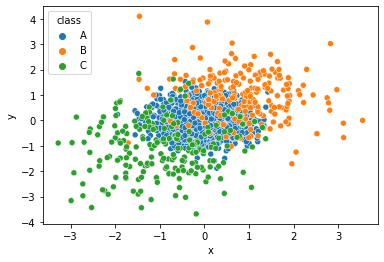

K-means classification scatterplot:


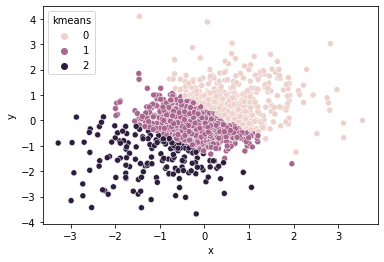

ARI imbalanced: 0.3551 ARI balanced: 0.436
AMI imbalanced: 0.3125 AMI balanced: 0.4328
Homogeneity imbalanced: 0.3557 Homogeneity balanced: 0.4278
Completeness imbalanced: 0.2802 Completeness balanced : 0.4391
V-measure imbalanced: 0.3135 V-measure balanced: 0.4334


<Figure size 432x288 with 0 Axes>

In [31]:
# Sample three classes, not that well separated, from gaussian distributions with 
# varying standard deviations and class size, such that the larger class is in 
# the middle and smaller classes on the edges  
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (1500, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = 1, scale = 1, size = (200, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = -1, scale = 1, size = (200, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 3, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7B_3_class_3_cluster_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7B_cluster_class_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7A_3_class_3_cluster_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7B_metrics_results.tsv",
    sep = "\t",
    index = False
)

### Case demonstration #3 - Single-cell dataset and Leiden clustering result with many smaller celltypes present 
 
This third use case examines a dataset of pancreatic islet cells with single-cell data from Celseq2. 

Here, quite a few celltypes are imbalanced, meaning that they are present in smaller number. The regular single-cell analysis workflow will be carried out and the cells will be clustered using Leiden clustering. From there, the imbalanced and balanced metrics for Leiden clustering will be compared, especially with respect to the clustering results for the smaller celltypes. The UMAP plot of these results will be examined.  

The results will be saved to tsv files to be plotted in R. 

Celltype scatterplot:


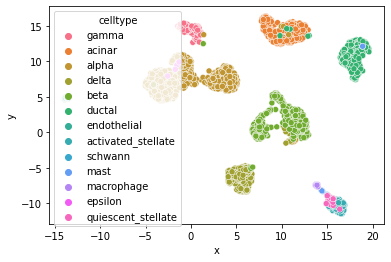

Leiden clustering scatterplot:


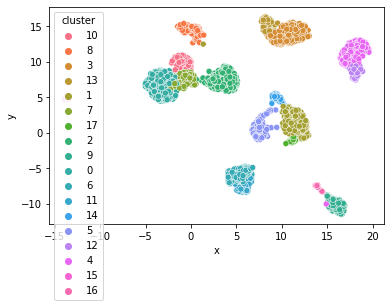

ARI imbalanced: 0.4931 ARI balanced: 0.5898
AMI imbalanced: 0.7636 AMI balanced: 0.8159
Homogeneity imbalanced: 0.938 Homogeneity balanced: 0.8095
Completeness imbalanced: 0.6503 Completeness balanced : 0.8293
V-measure imbalanced: 0.7681 V-measure balanced: 0.8193


<Figure size 432x288 with 0 Axes>

In [44]:
# Load the pancreatic dataset as a scanpy object
panc_adata = sc.read_h5ad("resources/h5ad_files/int_datasets/panc_4_batch/pancreas_filtered_only_celseq2.h5ad")

# Perform the typical single-cell analysis workflow, ending with Leiden clustering and UMAP embedding of the data
sc.pp.normalize_total(
    panc_adata,
    target_sum = 1e4
)
sc.pp.log1p(panc_adata)
sc.pp.highly_variable_genes(
    panc_adata,
    n_top_genes = 2500,
    flavor = "seurat"
)
sc.pp.pca(panc_adata, svd_solver="arpack")
sc.pp.neighbors(
    panc_adata,
    n_neighbors = 15,
    n_pcs = 20
)
sc.tl.leiden(panc_adata)
sc.tl.umap(panc_adata)

# Create a dataframe of the UMAP results with respect to the coordinates, celltypes, and leiden clustering results
umap_1 = panc_adata.obsm["X_umap"][:, 0]
umap_2 = panc_adata.obsm["X_umap"][:, 1]
celltypes = panc_adata.obs["celltype"].__array__()
clusters = panc_adata.obs["leiden"].__array__()
cluster_df = pd.DataFrame({
    "x" : umap_1,
    "y" : umap_2,
    "celltype": celltypes,
    "cluster": clusters
})

# Plot the celltype data
print("Celltype scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "celltype",
    data = cluster_df
)
plt.show()
plt.clf()

# Plot the cluster results data
print("Leiden clustering scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "cluster",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7C_panc_data_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7C_cluster_celltype_imbal_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7C_cluster_celltype_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7C_cluster_celltype_results.tsv",
    sep = "\t",
    index = False
)

alpha                 843
beta                  445
acinar                274
ductal                258
delta                 203
gamma                 110
activated_stellate     90
endothelial            21
macrophage             15
quiescent_stellate     12
mast                    6
epsilon                 4
schwann                 4
Name: celltype, dtype: int64